# Import required libraries

In [239]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score

# Load dataset

* Mount Google Drive to access the dataset
* Read Bitcoin price dataset from a CSV file in Google Drive


In [219]:
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/My Drive/BTC-USD.csv')
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-26,11256.000000,11656.700195,10470.299805,11171.400391,11171.400391,9746199552
1,2018-01-27,11174.900391,11614.900391,10989.200195,11440.700195,11440.700195,7583269888
2,2018-01-28,11475.299805,12040.299805,11475.299805,11786.299805,11786.299805,8350360064
3,2018-01-29,11755.500000,11875.599609,11179.200195,11296.400391,11296.400391,7107359744
4,2018-01-30,11306.799805,11307.200195,10036.200195,10106.299805,10106.299805,8637859840


* Extract the "close" prices and transform them into a column vector


In [220]:
price = df['Close'].values.reshape(-1, 1)

* Display prices in the form of a price-time chart

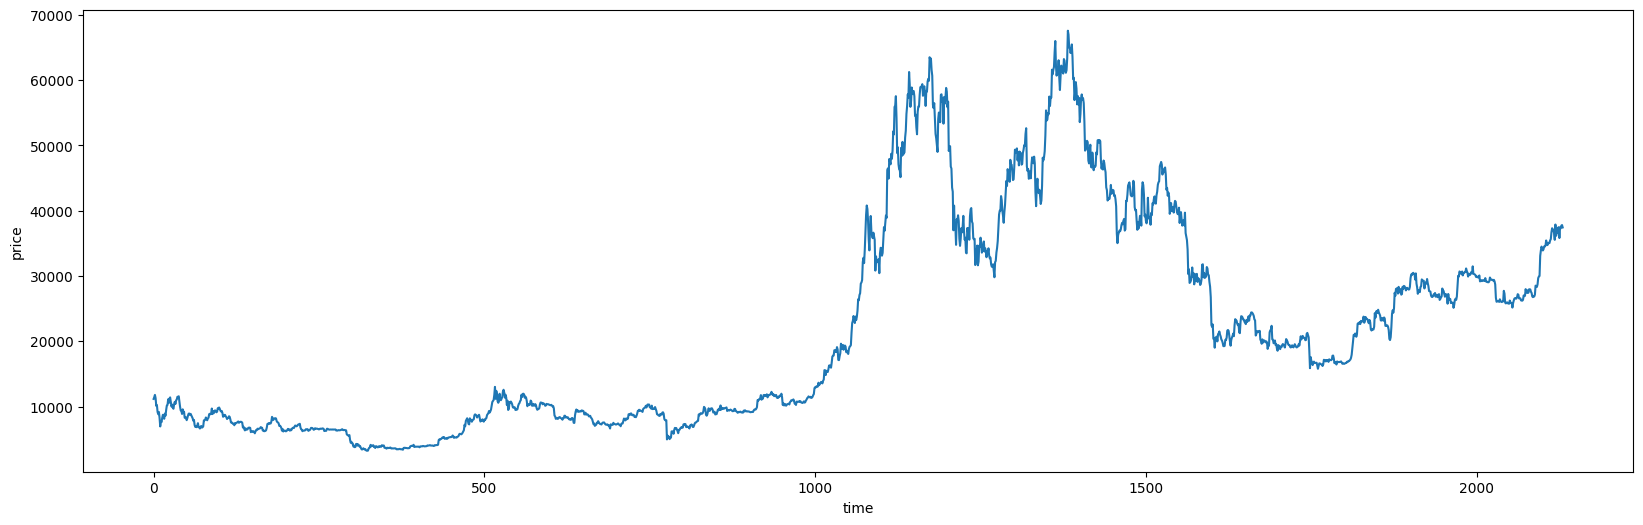

In [221]:
plt.figure(figsize=(20, 6))
plt.plot(price, label='Original Close')
plt.xlabel("time")
plt.ylabel("price")
plt.show()

# Apply the Fourier transform to the data and remove the noise

Apply Fast Fourier Transform to a time series and filter out high-frequency components.

Parameters:
- price (numpy.ndarray): Time series data.
- cutoff_frequency (float): The cutoff frequency for filtering high-frequency components.

Returns:
- filtered_price (numpy.ndarray): Time series data after filtering.



In [222]:
def fast_fourier_transform(price, cutoff_frequency):
    fft_result = np.fft.fft(price, axis=0)
    fft_freq = np.fft.fftfreq(len(price), 1)

    high_freq_indices = np.abs(fft_freq) > cutoff_frequency
    fft_result[high_freq_indices, :] = 0

    filtered_price = np.fft.ifft(fft_result, axis=0).real
    return filtered_price

* Display several types of filters


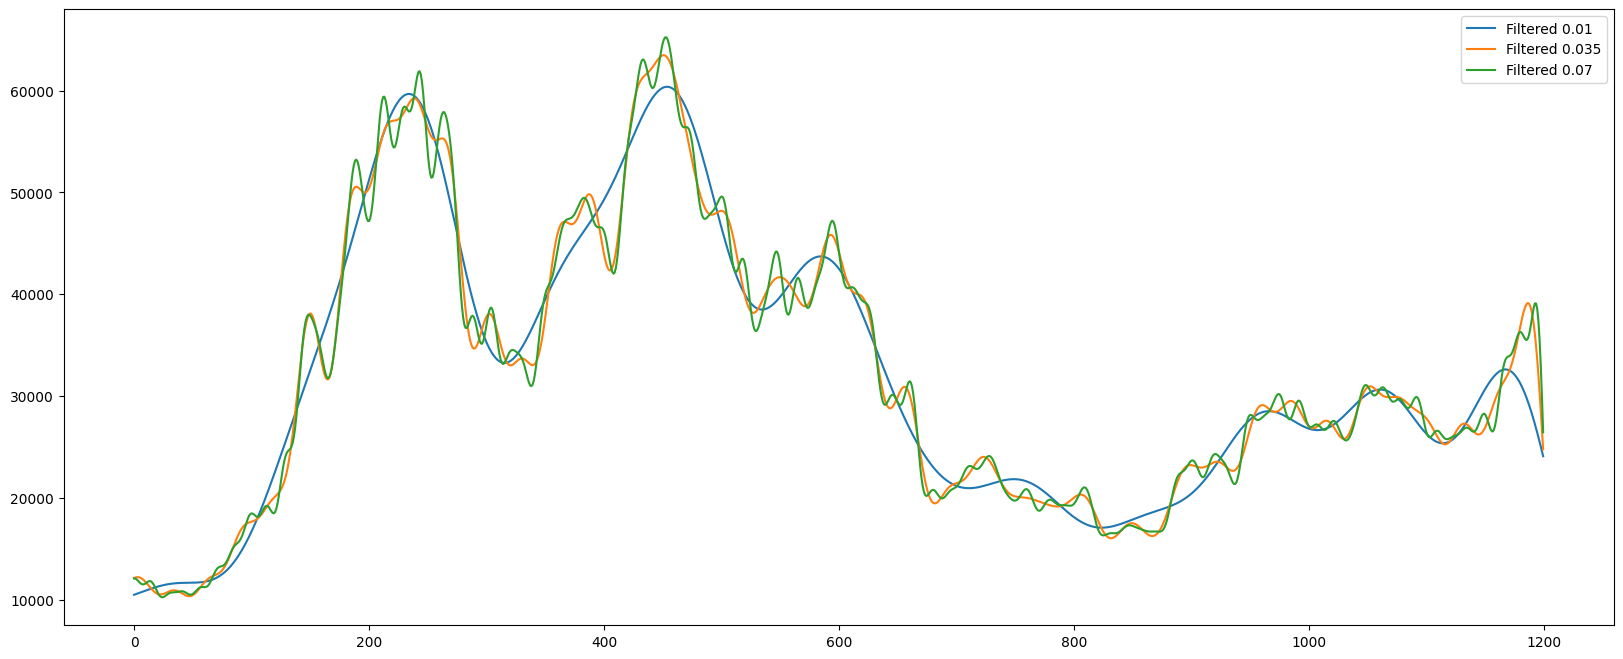

In [223]:
filtered_price1 = fast_fourier_transform(price, 0.01)
filtered_price2 = fast_fourier_transform(price, 0.035)
filtered_price3 = fast_fourier_transform(price, 0.07)

plt.figure(figsize=(20, 8))
plt.plot(filtered_price1[-1200:], label='Filtered 0.01')
plt.plot(filtered_price2[-1200:], label='Filtered 0.035')
plt.plot(filtered_price3[-1200:], label='Filtered 0.07')
plt.legend()
plt.show()

* Display prices and filter price

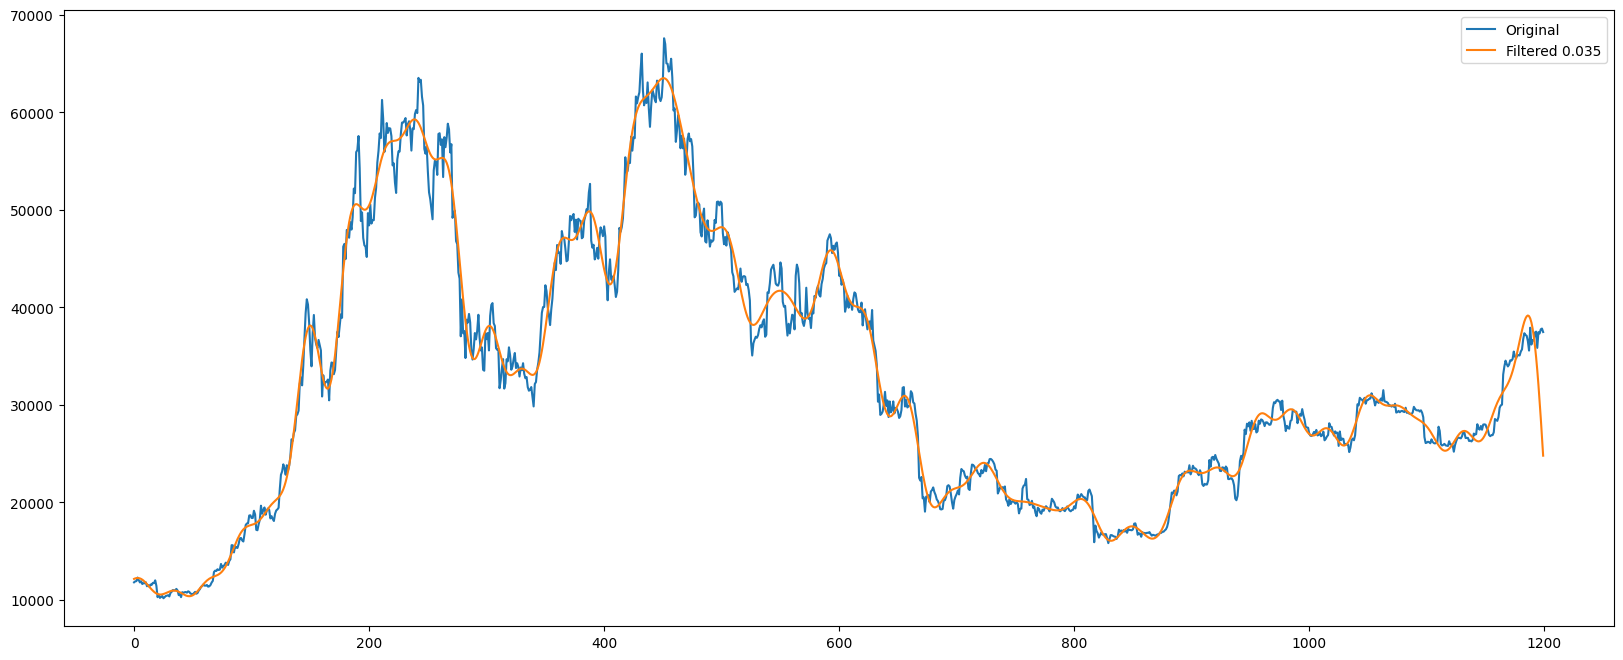

In [224]:
filtered_price = fast_fourier_transform(price, 0.035)

plt.figure(figsize=(20, 8))
plt.plot(price[-1200:], label='Original')
plt.plot(filtered_price[-1200:], label='Filtered 0.035')
plt.legend()
plt.show()

# Prepare data for processing

* Apply scaling to the filtered price data

In [225]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(filtered_price)

* Splitting data into training and testing

In [226]:
train_size = int(len(prices_scaled) * 0.75)
train_data, test_data = prices_scaled[:train_size], prices_scaled[train_size:]

Create input-output pairs for time series data to be used in sequence models.

Parameters:
- dataset (numpy.ndarray): The time series dataset.
- time_steps (int): The number of time steps to be used for creating each input-output pair.

Returns:
- X (numpy.ndarray): Input sequences.
- Y (numpy.ndarray): Output values corresponding to the input sequences.


In [227]:
def create_window(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

* Define the number of time steps for creating input-output pairs
* Create input-output pairs for training data
* Create input-output pairs for testing data
* Reshape the input sequences for compatibility with LSTM model



In [228]:
time_steps = 10
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Building a neural network model

Create and compile an LSTM-based neural network model for time series prediction.

Parameters:
- shape (tuple): Shape of the input data (number of time steps, number of features).

Returns:
- model (tensorflow.keras.models.Sequential): Compiled LSTM model for time series prediction.


In [246]:
def create_model(shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=shape))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    return model

* Create the LSTM model using the specified input shape
* Train the model on the training data



In [247]:
model = create_model((X_train.shape[1], 1))

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 100)           40800     
                                                                 
 lstm_7 (LSTM)               (None, 10, 100)           80400     
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 64)                6464      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 208129 (813.00 KB)
Trainable params: 208129 (813.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
50

# Display the loss function

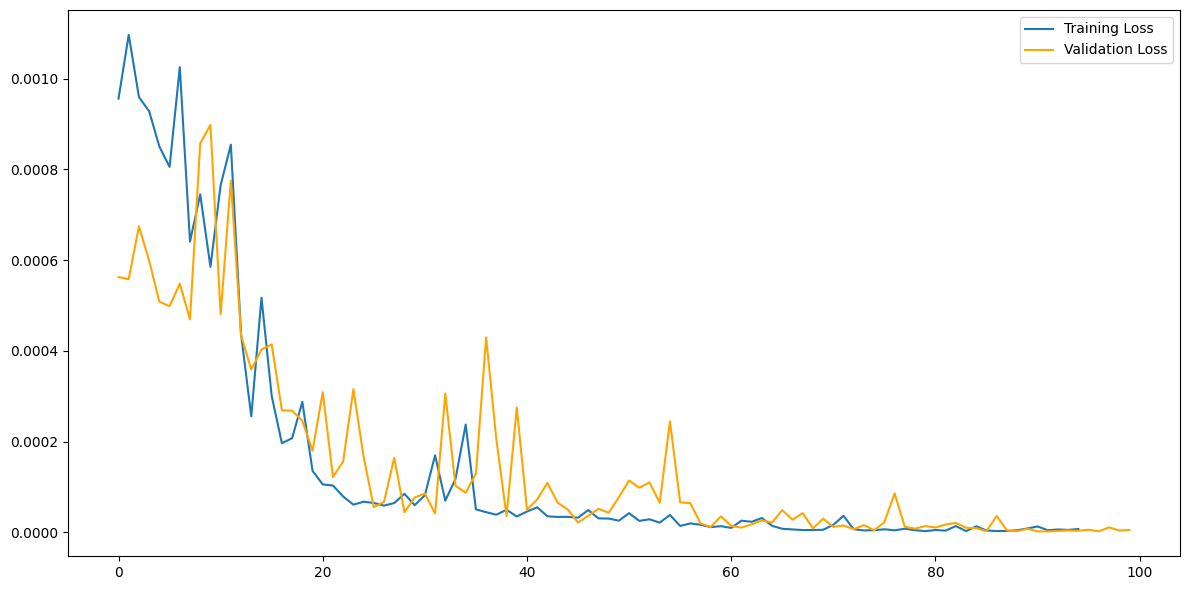

In [248]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][5:], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.legend()

plt.tight_layout()
plt.show()

# Network test

* Evaluate the model on the test data
* Calculate R-squared
* Display evaluation results

In [250]:
test_loss = model.evaluate(X_test, y_test)
r_squared = r2_score(y_test_original, predicted_prices)

print(f'R-squared: {round(r_squared, 3) * 100} %')
print(f'Test Loss: {test_loss}')

17/17 [==============================] - 0s 10ms/step - loss: 5.2493e-06
R-squared: 99.8 %
Test Loss: 5.249336936685722e-06


17/17 [==============================] - 0s 9ms/step


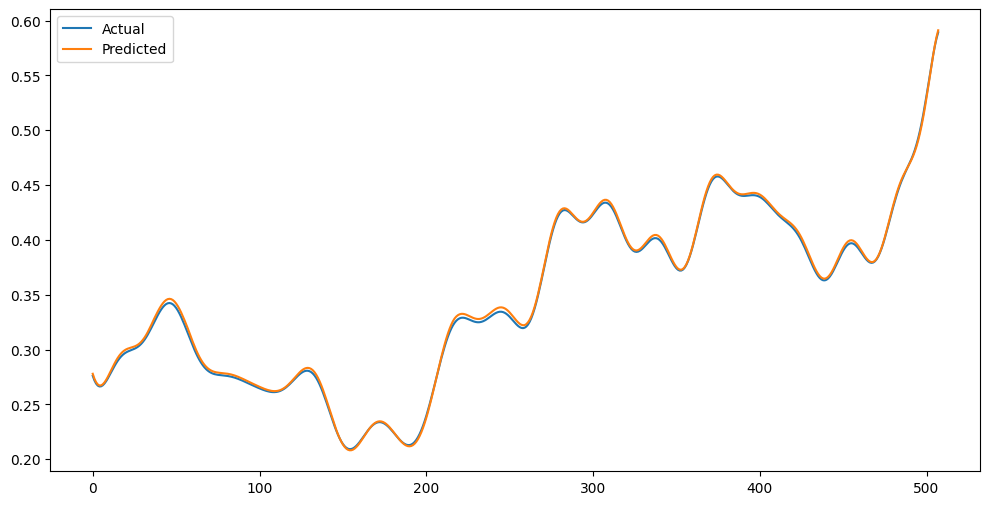

In [266]:
predicted = model.predict(X_test)


plt.figure(figsize=(12, 6))
plt.plot(y_test[:-15], label='Actual')
plt.plot(predicted[:-15], label='Predicted')
plt.legend()
plt.show()

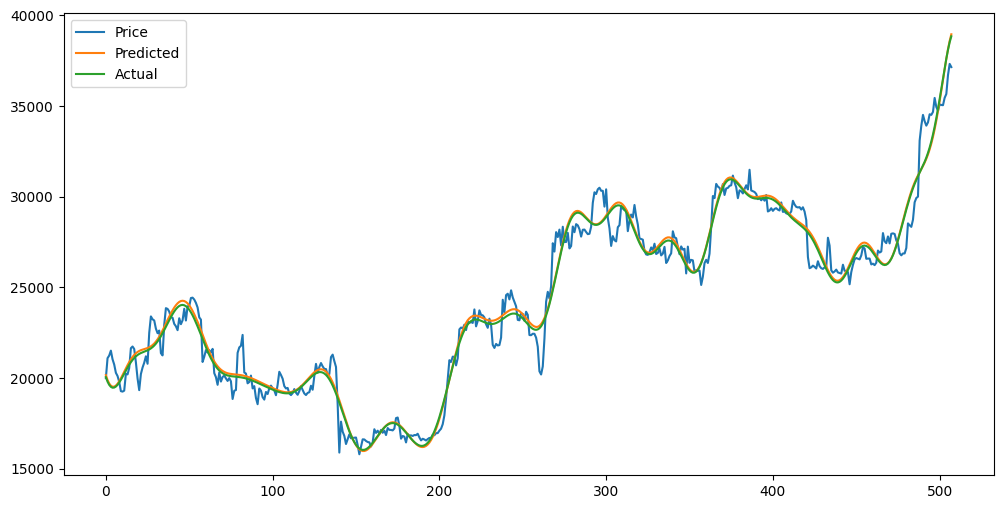

In [265]:
predicted_prices = scaler.inverse_transform(predicted)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(12, 6))
plt.plot(price[-523:-15], label='Price')
plt.plot(predicted_prices[:-15], label='Predicted')
plt.plot(y_test_original[:-15], label='Actual')
plt.legend()
plt.show()